# Problem Statement :- SMS SPAM Classification 

## Problem Statement: 
Over recent years, as the popularity of mobile phone devices has increased, Short Message Service (SMS) has grown into a multi-billion dollar industry. At the same time, reduction in the cost of messaging services has resulted in growth in unsolicited commercial advertisements (spams) being sent to mobile phones. Due to Spam SMS, Mobile service providers suffer from some sort of financial problems as well as it reduces calling time for users. Unfortunately, if the user accesses such Spam SMS they may face the problem of virus or malware. When SMS arrives at mobile it will disturb mobile user privacy and concentration. It may lead to frustration for the user. So Spam SMS is one of the major issues in the wireless communication world and it grows day by day. 


## Method
We will use Dense text classifier , Long Short Term Memory(LSTM) and Bi-directional LSTM and compare these methods in terms of performance and runtime. 

The work here is broken down in multiple steps:

* Load and explore the spam data
* Prepare train test data
* Train the spam detection model using the three approaches metioned earlier
* Select one as a final model
* Use the final trained classifier to classify the text


##Import Required Libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [1]:
# import libarries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional


## Load and explore the dataset



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/IBM_Project/Dataset/spam.csv" "sample_data/"

In [9]:
messages = pd.read_csv("sample_data/spam.csv",encoding = 'latin-1')
messages.drop(messages.columns[[2, 3, 4]], axis=1,inplace=True)
messages.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [ ]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [ ]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [ ]:
# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In [ ]:
ham_msg_text[:300]

"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... Ok lar... Joking wif u oni... U dun say so early hor... U c already then say... Nah I don't think he goes to usf, he lives around here though Even my brother is not like to speak with me. "

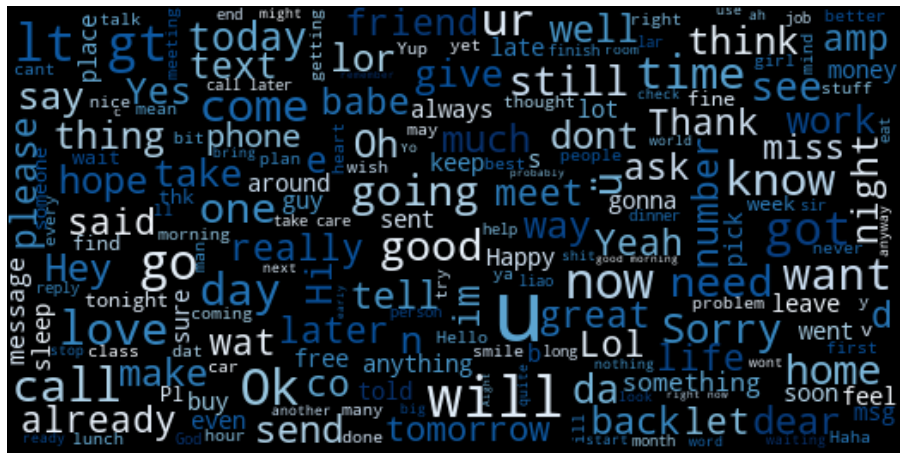

In [ ]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

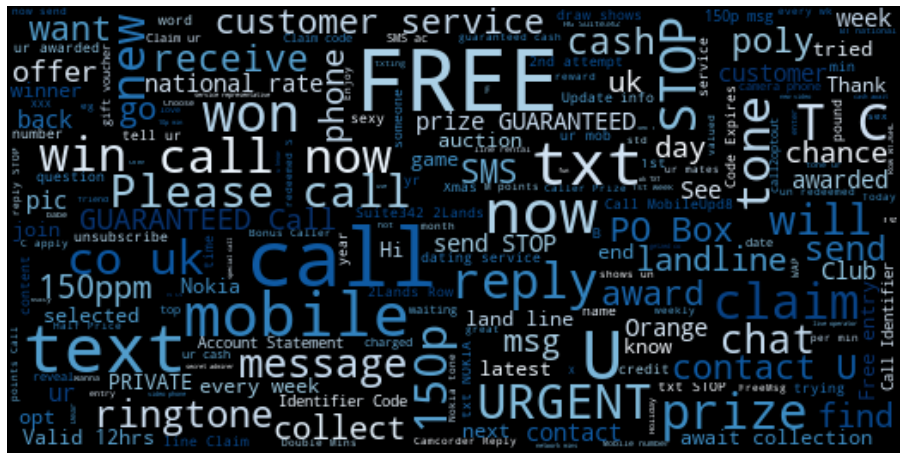

In [ ]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of ham and spam email messages')

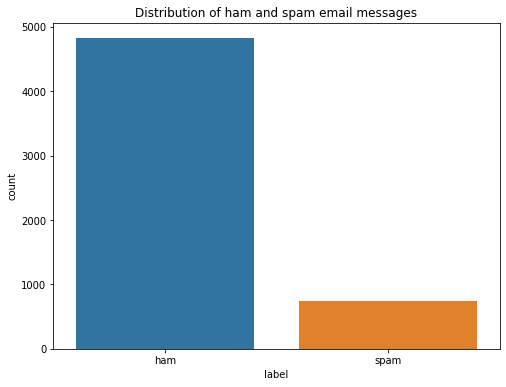

In [ ]:
# we can observe imbalance data here. 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
plt.title('Distribution of ham and spam email messages')

In [ ]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

15.481865284974095

In [ ]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [ ]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [ ]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

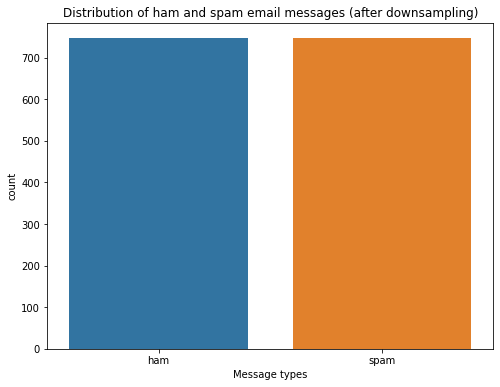

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [ ]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,73.238286
spam,138.670683


## Prepare train test data and pre-processing text


In [ ]:
#msg_df['msg_type']= msg_df['label'].apply(lambda x: 1 if x =='spam' else 0)
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [ ]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

#### Tokenization


In [ ]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [ ]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


#### Sequencing and Padding



In [ ]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

In [ ]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
# Before padding : first sequence is 27 character long where as second one is 24
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [ ]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [ ]:
# As can be seen from below, the padded sequence is 50 words long. 
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Train the Model

#### Dense Spam Detection Architechture



In [ ]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

## Add layers

In [ ]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

## Compile the model

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [ ]:
# Compile model
#from tensorflow import keras
# Using Adam optimiser which makes use of momentum to avoid local minima
#optim = keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [ ]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6825 - accuracy: 0.4996 - val_loss: 0.6704 - val_accuracy: 0.5686 - 883ms/epoch - 23ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6544 - accuracy: 0.6544 - val_loss: 0.6315 - val_accuracy: 0.6388 - 96ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6054 - accuracy: 0.6987 - val_loss: 0.5743 - val_accuracy: 0.7659 - 98ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5428 - accuracy: 0.8318 - val_loss: 0.5138 - val_accuracy: 0.8194 - 134ms/epoch - 4ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4749 - accuracy: 0.8711 - val_loss: 0.4532 - val_accuracy: 0.8495 - 117ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.4042 - accuracy: 0.8895 - val_loss: 0.3901 - val_accuracy: 0.8696 - 114ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3419 - accuracy: 0.9038 - val_loss: 0.3334 - val_accuracy: 0.8863 - 110ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2868 - accuracy: 0.9113 - val_loss: 0.2857 - val_accuracy: 0.8896 - 107ms/epoch - 3ms/step
Epoch 9/30
38/38 

## Test the model

In [ ]:
# Model performermance on test data is about 9465% accuracy with validation loss of 0.11.
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.1386 - accuracy: 0.9431


[0.13855192065238953, 0.9431437849998474]

In [ ]:
metrics = pd.DataFrame(history.history)
metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.682487,0.499582,0.670359,0.568562
1,0.654387,0.654393,0.631534,0.638796


In [ ]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.682487,0.499582,0.670359,0.568562
1,0.654387,0.654393,0.631534,0.638796


In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

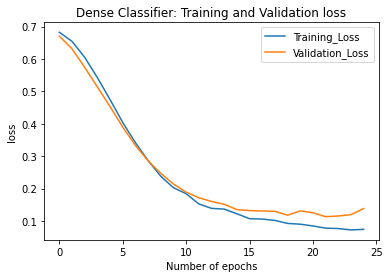

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

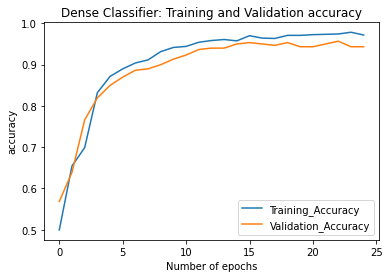

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

#### Long Short Term Memory (LSTM) layer architecture 



In [ ]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

## Add layers

In [ ]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))
model1.add(GlobalAveragePooling1D())

## Compile the model

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 7s - loss: 0.6418 - accuracy: 0.6912 - val_loss: 0.5280 - val_accuracy: 0.8161 - 7s/epoch - 186ms/step
Epoch 2/30
38/38 - 2s - loss: 0.3539 - accuracy: 0.8904 - val_loss: 0.2772 - val_accuracy: 0.9197 - 2s/epoch - 54ms/step
Epoch 3/30
38/38 - 2s - loss: 0.2289 - accuracy: 0.9356 - val_loss: 0.2170 - val_accuracy: 0.9398 - 2s/epoch - 56ms/step
Epoch 4/30
38/38 - 2s - loss: 0.1831 - accuracy: 0.9556 - val_loss: 0.2353 - val_accuracy: 0.9164 - 2s/epoch - 42ms/step
Epoch 5/30
38/38 - 2s - loss: 0.1504 - accuracy: 0.9665 - val_loss: 0.1744 - val_accuracy: 0.9465 - 2s/epoch - 42ms/step
Epoch 6/30
38/38 - 2s - loss: 0.1393 - accuracy: 0.9690 - val_loss: 0.1849 - val_accuracy: 0.9365 - 2s/epoch - 42ms/step
Epoch 7/30
38/38 - 2s - loss: 0.1193 - accuracy: 0.9741 - val_loss: 0.1454 - val_accuracy: 0.9532 - 2s/epoch - 42ms/step
Epoch 8/30
38/38 - 2s - loss: 0.1081 - accuracy: 0.9774 - val_loss: 0.1904 - val_accuracy: 0.9398 - 2s/epoch - 43ms/step
Epoch 9/30
38/38 - 2s - loss: 0

In [ ]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

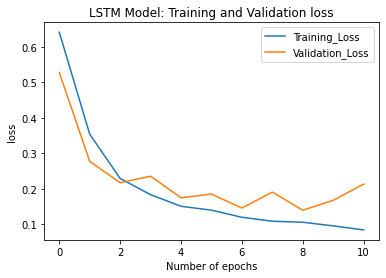

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

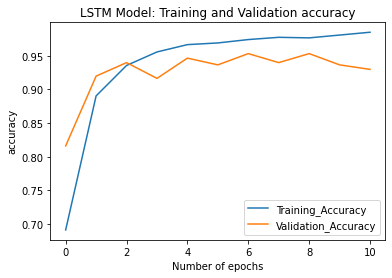

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

#### Biderectional LSTM (Bi-LSTM) Spam detection architecture


## Add layers

In [ ]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))
model2.add(GlobalAveragePooling1D())

## Compile the model

In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

## Fit the model

In [ ]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 6s - loss: 0.6679 - accuracy: 0.7364 - val_loss: 0.5870 - val_accuracy: 0.8261 - 6s/epoch - 159ms/step
Epoch 2/30
38/38 - 1s - loss: 0.3987 - accuracy: 0.8946 - val_loss: 0.2992 - val_accuracy: 0.9064 - 1s/epoch - 32ms/step
Epoch 3/30
38/38 - 1s - loss: 0.2257 - accuracy: 0.9314 - val_loss: 0.2037 - val_accuracy: 0.9398 - 1s/epoch - 33ms/step
Epoch 4/30
38/38 - 1s - loss: 0.1718 - accuracy: 0.9439 - val_loss: 0.1744 - val_accuracy: 0.9431 - 1s/epoch - 32ms/step
Epoch 5/30
38/38 - 1s - loss: 0.1383 - accuracy: 0.9548 - val_loss: 0.1596 - val_accuracy: 0.9365 - 1s/epoch - 31ms/step
Epoch 6/30
38/38 - 1s - loss: 0.1158 - accuracy: 0.9615 - val_loss: 0.1416 - val_accuracy: 0.9465 - 1s/epoch - 32ms/step
Epoch 7/30
38/38 - 1s - loss: 0.0993 - accuracy: 0.9674 - val_loss: 0.1731 - val_accuracy: 0.9298 - 1s/epoch - 31ms/step
Epoch 8/30
38/38 - 1s - loss: 0.0875 - accuracy: 0.9699 - val_loss: 0.1368 - val_accuracy: 0.9498 - 1s/epoch - 31ms/step
Epoch 9/30
38/38 - 1s - loss: 0

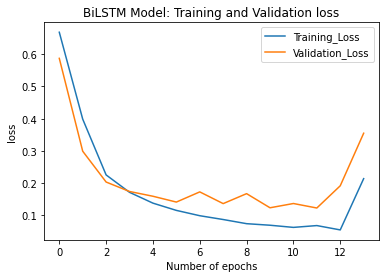

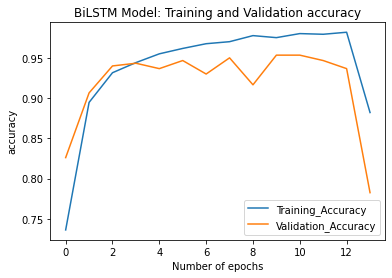

In [ ]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Compare three different models


In [ ]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 2ms/step - loss: 0.1386 - accuracy: 0.9431
Dense architecture loss and accuracy: [0.13855192065238953, 0.9431437849998474] 
10/10 [==============================] - 0s 12ms/step - loss: 0.2130 - accuracy: 0.9298
LSTM architecture loss and accuracy: [0.21296323835849762, 0.9297658801078796] 
10/10 [==============================] - 0s 9ms/step - loss: 0.3549 - accuracy: 0.7826
Bi-LSTM architecture loss and accuracy: [0.3549480438232422, 0.782608687877655] 


# Predict sentiment for new messages



## Save the model as .h5 file

In [ ]:
model.save('sms_classifier.h5')

In [ ]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [ ]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [ ]:
predict_spam(predict_msg)

1/1 [==============================] - 0s 90ms/step


array([[0.02247783],
       [0.0103093 ],
       [0.9991211 ]], dtype=float32)

In [ ]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 20ms/step


array([[0.9405261 ],
       [0.07335175],
       [0.03204051]], dtype=float32)